### OCP Data Preprocessing Tutorial


This notebook provides an overview of converting ASE Atoms objects to PyTorch Geometric Data objects. To better understand the raw data contained within OC20, check out the following tutorial first: https://github.com/Open-Catalyst-Project/ocp/blob/master/docs/source/tutorials/data_visualization.ipynb

In [3]:
from ocpmodels.preprocessing import AtomsToGraphs
import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule, fcc111
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import sys
import numpy as np
import matplotlib.pyplot as plt

### Generate toy dataset: Relaxation of CO on Cu

Cell([[5.105310960166873, 0.0, 0.0], [2.5526554800834367, 4.421328985723636, 0.0], [0.0, 0.0, 0.0]])


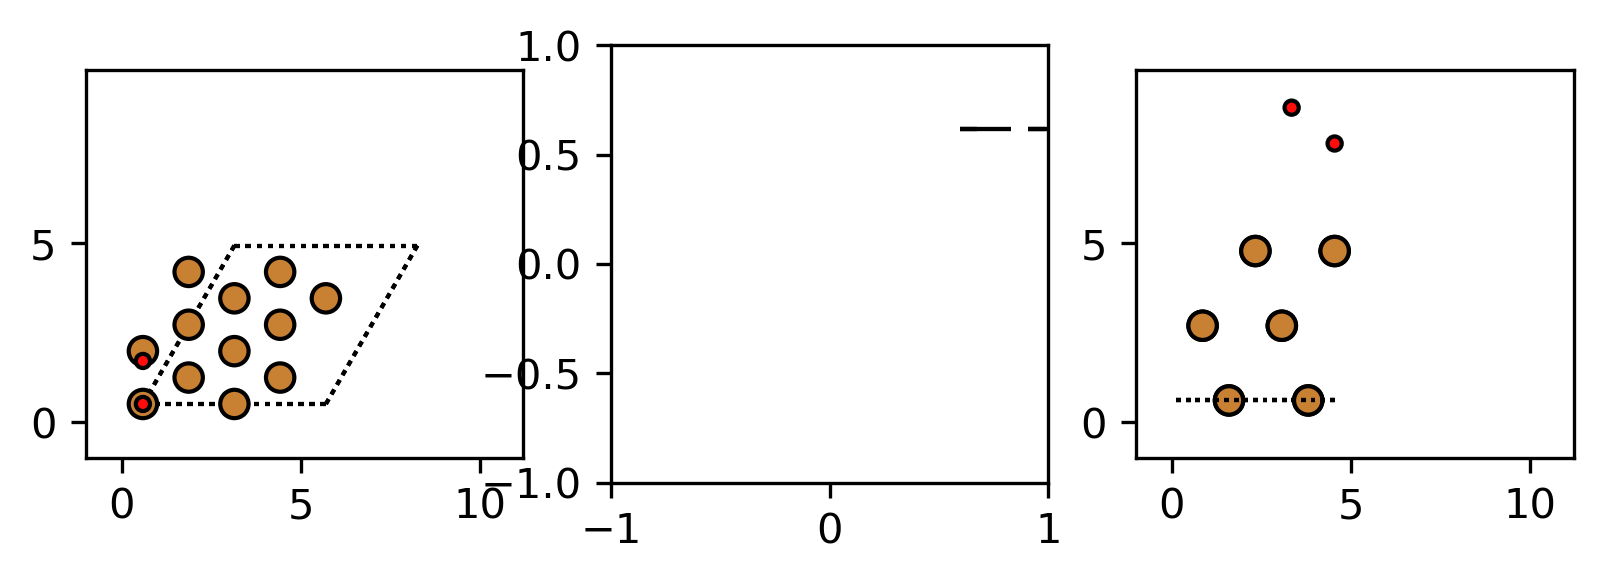

In [7]:
adslab = fcc111("Cu", size=(2, 2, 3))
ads = molecule("O2",positions=[(0, 0, 0), (0, 1.2, 1)])
add_adsorbate(adslab, ads, 3, position=(0,0) ,offset=(0, 0))  
# add_adsorbate(slab, adsorbate, height, position=(0, 0), offset=None, mol_index=0)
# The default value of the parameter "position" is set to the coordinates of the first atom in the adsorption configuration.
# The parameter "height" is the height of the first atom in the molecule
# print(adslab.info)
# help(add_adsorbate)
# help(ase.visualize)
fig, axs = plt.subplots(1, 3, dpi=300)

# 绘制第一个子图（俯视图）
print(adslab.cell)
axs[0].set_aspect('equal')
plot_atoms(adslab, axs[0], radii=0.3, rotation=('0x,0y,0z'))
axs[0].set_xlim(-1, adslab.cell[0,0]*2+1)
axs[0].set_ylim(-1, adslab.cell[1,1]*2+1)
# 绘制第二个子图（侧视图）
axs[1].set_aspect('equal')
plot_atoms(adslab, axs[1], radii=0.3, rotation=('-90x,0y,0z'))
axs[1].set_xlim(-1, adslab.cell[0,2]*2+1)
axs[1].set_ylim(-1, adslab.cell[1,2]*2+1)

# 绘制第个子图（侧视图）
axs[2].set_aspect('equal')
plot_atoms(adslab, axs[2], radii=0.3, rotation=('-90x,90y,0z'))
axs[2].set_xlim(-1, adslab.cell[0,0]*2+1)
axs[2].set_ylim(-1, adslab.cell[1,1]*2+1)
plt.show()



In [6]:
help(view)

Help on function view in module ase.visualize:

view(atoms, data=None, viewer='ase', repeat=None, block=False)



### Convert Atoms object to Data object

The AtomsToGraphs class takes in several arguments to control how Data objects created:

- max_neigh (int):   Maximum number of neighbors a given atom is allowed to have, discarding the furthest
- radius (float):      Cutoff radius to compute nearest neighbors around
- r_energy (bool):    Write energy to Data object
- r_forces (bool):    Write forces to Data object
- r_distances (bool): Write distances between neighbors to Data object
- r_edges (bool):     Write neigbhor edge indices to Data object
- r_fixed (bool):     Write indices of fixed atoms to Data object

In [5]:
a2g = AtomsToGraphs(
    max_neigh=50,
    radius=6,
    r_energy=True,
    r_forces=True,
    r_distances=False,
    r_edges=True,
    r_fixed=True,
)  
# This code segment establishes a method for transforming atomic structures into graphical objects, preparing them for machine learning and other applications.

In [6]:
raw_data = ase.io.read("CuCO_adslab.traj", ":")
type(raw_data)

33
[Atoms(symbols='Cu12OC', pbc=True, cell=[5.105310960166873, 5.105310960166873, 32.61], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3]), calculator=SinglePointCalculator(...)), Atoms(symbols='Cu12OC', pbc=True, cell=[5.105310960166873, 5.105310960166873, 32.61], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3]), calculator=SinglePointCalculator(...)), Atoms(symbols='Cu12OC', pbc=True, cell=[5.105310960166873, 5.105310960166873, 32.61], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3]), calculator=SinglePointCalculator(...)), Atoms(symbols='Cu12OC', pbc=True, cell=[5.105310960166873, 5.105310960166873, 32.61], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3]), calculator=SinglePointCalculator(...)), Atoms(symbols='Cu12OC', pbc=True, cell=[5.105310960166873, 5.105310960166873, 32.61], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3]), calculator=SinglePointCalculator(...)), Atoms(symbols='Cu12OC', pbc=True, cell=[5.105310960166873, 5.105310960166873, 32.61], tags=..., const

list

In [7]:
data_objects = a2g.convert_all(raw_data, disable_tqdm=True)

/home/zwbai/ocp/ocpmodels/preprocessing/atoms_to_graphs.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525495809/work/torch/csrc/utils/tensor_new.cpp:230.)
  cell = torch.Tensor(atoms.get_cell()).view(1, 3, 3)


In [8]:
data = data_objects[0]
print(data)
data.atomic_numbers

Data(pos=[14, 3], cell=[1, 3, 3], atomic_numbers=[14], natoms=14, tags=[14], edge_index=[2, 636], cell_offsets=[636, 3], y=3.989314410668539, force=[14, 3], fixed=[14])


tensor([29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,  8.,  6.])

In [9]:
data.cell

tensor([[[ 5.1053,  0.0000,  0.0000],
         [ 0.0000,  5.1053,  0.0000],
         [ 0.0000,  0.0000, 32.6100]]])

In [10]:
data.edge_index #neighbor idx, source idx

tensor([[ 1,  2,  2,  ...,  4,  6,  3],
        [ 0,  0,  0,  ..., 13, 13, 13]])

In [11]:
from torch_geometric.utils import degree
# Degree corresponds to the number of neighbors a given node has. Note there is no more than max_neigh neighbors for any given node.

degree(data.edge_index[1])

tensor([45., 45., 45., 46., 49., 49., 49., 49., 50., 49., 49., 50., 26., 35.])

In [12]:
data.fixed

tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
data.force

tensor([[ 9.9356e-16,  4.5465e-15,  1.1354e-01],
        [ 2.6749e-15,  3.7696e-15,  1.1344e-01],
        [ 8.4481e-16,  2.7062e-16,  1.1344e-01],
        [-6.6623e-18,  6.6196e-17,  1.1294e-01],
        [-8.5221e-03, -8.5221e-03, -1.1496e-02],
        [ 8.5221e-03, -8.5221e-03, -1.1496e-02],
        [-8.5221e-03,  8.5221e-03, -1.1496e-02],
        [ 8.5221e-03,  8.5221e-03, -1.1496e-02],
        [ 1.9082e-17,  9.6277e-16, -1.0431e-01],
        [-2.0583e-15, -4.3021e-16, -6.6610e-02],
        [-5.5511e-17, -2.3592e-15, -6.6610e-02],
        [-2.9409e-17, -4.3038e-15, -3.3250e-01],
        [ 3.3204e-19,  6.7763e-21, -3.4247e-01],
        [-4.5103e-17, -5.2042e-17,  5.0512e-01]])

In [14]:
data.pos

tensor([[ 0.0000,  0.0000, 13.0000],
        [ 2.5527,  0.0000, 13.0000],
        [ 0.0000,  2.5527, 13.0000],
        [ 2.5527,  2.5527, 13.0000],
        [ 1.2763,  1.2763, 14.8050],
        [ 3.8290,  1.2763, 14.8050],
        [ 1.2763,  3.8290, 14.8050],
        [ 3.8290,  3.8290, 14.8050],
        [ 0.0000,  0.0000, 16.6100],
        [ 2.5527,  0.0000, 16.6100],
        [ 0.0000,  2.5527, 16.6100],
        [ 2.5527,  2.5527, 16.6100],
        [ 2.5527,  2.5527, 19.6100],
        [ 2.5527,  2.5527, 18.4597]])

In [15]:
data.y

3.989314410668539

### Adding additional info to your Data objects

In addition to the above information, the OCP repo requires several other pieces of information for your data to work
with the provided trainers:

- sid (int): A unique identifier for a particular system. Does not affect your model performance, used for prediction saving 
- fid (int) (S2EF only): If training for the S2EF task, your data must also contain a unique frame identifier for atoms objects coming from the same system.
- tags (tensor): Tag information - 0 for subsurface, 1 for surface, 2 for adsorbate. Optional, can be used for training.

Other information may be added her as well if you choose to incorporate other information in your models/frameworks

In [16]:
data_objects = []
for idx, system in enumerate(raw_data):
    data = a2g.convert(system)
    data.fid = idx
    data.sid = 0 # All data points come from the same system, arbitrarly define this as 0
    data_objects.append(data)

In [17]:
data = data_objects[0]
data

Data(pos=[14, 3], cell=[1, 3, 3], atomic_numbers=[14], natoms=14, tags=[14], edge_index=[2, 636], cell_offsets=[636, 3], y=3.989314410668539, force=[14, 3], fixed=[14], fid=0, sid=0)

In [18]:
data.sid

0

In [19]:
data.fid

0

Resources:

- https://github.com/Open-Catalyst-Project/ocp/blob/6604e7130ea41fabff93c229af2486433093e3b4/ocpmodels/preprocessing/atoms_to_graphs.py
- https://github.com/Open-Catalyst-Project/ocp/blob/master/scripts/preprocess_ef.py